# Exercise 5: Regularized Linear Regression and Bias vs. Variance

In this exercise, regularized linear regression is implemented to study models with different bias-variance properties.

Files provided by Coursera, located under `../exercises/ex1-ex8-octave/ex5`

- `ex5.m` - Octave/MATLAB script that steps you through the exercise
- `ex5data1.mat` - Dataset
- `submit.m` - Submission script that sends your solutions to our servers
- `featureNormalize.m` - Feature normalization function
- `fmincg.m` - Function minimization routine (similar to `fminunc`)
- `plotFit.m` - Plot a polynomial fit
- `trainLinearReg.m` - Trains linear regression using your cost function

Files to complete:

- `linearRegCostFunction.m` - Regularized linear regression cost function
- `learningCurve.m` - Generates a learning curve
- `polyFeatures.m` - Maps data into polynomial feature space
- `validationCurve.m` - Generates a cross validation curve

Workflow:

- Download latest Octave version of exercise from Coursera
- Complete code in exercise files following `ex5.pdf`
- Whenever an exercise part is finished
  - Check it with `ex5` in Octave terminal
  - Create a submission token on Coursera (exercise submission page, it lasts 30 minutes)
  - Execute `submit` in Octave terminal
  - Introduce email and token
  - Results appear

**Overview of contents:**

0. Setup: `gnuplot`
1. Dataset Loading & Visualization


## 0. Setup: `gnuplot`

In [93]:
graphics_toolkit ("gnuplot");

In [94]:
%plot -b inline:gnuplot

## 1. Dataset Loading & Visualization

In [95]:
% Load saved matrices from file
load('ex5data1.mat');

In [96]:
who

Variables visible from the current scope:

J            X_poly_test  Xval         grad         p            y
X            X_poly_val   ans          lambda       sigma        ytest
X_norm       Xp           error_train  m            theta        yval
X_poly       Xtest        error_val    mu           x



In [97]:
size(X)

ans =

   12    1



In [98]:
size(y)

ans =

   12    1



In [99]:
m = size(X,1);

ans = -52.828


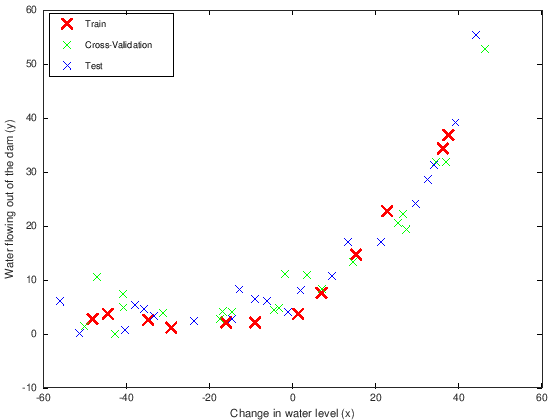

In [100]:
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 5);
hold on;
plot(Xval, yval, 'gx', 'MarkerSize', 7, 'LineWidth', 1.5);
plot(Xtest, ytest, 'bx', 'MarkerSize', 7, 'LineWidth', 1.5);
legend('Train', 'Cross-Validation', 'Test','location','northwest')
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');

## 2. Regularized Linear Regression

### 2.1 Regularized Linear Regression: Cost Function & Gradient -- `linearRegCostFunction.m`

Cost function:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

Gradient:

$$
\begin{align}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} & \qquad \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \qquad \text{for } j \ge 1
\end{align}
$$



In [101]:
function [J, grad] = linearRegCostFunction_(X, y, theta, lambda)
    % Number of training examples
    m = length(y); 
    % Init return variables
    J = 0;
    grad = zeros(size(theta));
    
    % Cost (without regularization)
    h = X*theta; % (m x (n+1)) x ((n+1) x 1) -> m x 1
    e = (h - y); % m x 1
    J = (0.5/m) * (e'*e);
    % Regularization term
    t = theta(2:end,:); % n x 1
    J = J + ((0.5*lambda/m) * (t'*t));
    
    % Gradient (without regularization)
    grad = (1/m) * (e'*X); % (1 x m) x (m x (n+1)) -> 1 x (n+1)
    % Regularization term
    r = (lambda/m) * theta(2:end,1); % n x 1
    grad = grad' + [0; r];
    
    % Column vector
    grad = grad(:);
end


In [102]:
theta = ones(size(X,2)+1,1); % (n+1) x 1
Xp = [ones(size(X,1),1), X]; % m x (n+1)
lambda = 1;

In [103]:
[J, grad] = linearRegCostFunction_(Xp, y, theta, lambda);

In [104]:
J

J = 303.99


In [105]:
grad

grad =

   -15.303
   598.251



### 2.2 Train and Plot Fitted Line -- `trainLinearReg.m`

In [106]:
function [theta] = trainLinearReg_(X, y, lambda)
    initial_theta = zeros(size(X, 2), 1); 
    % Create "short hand" for the cost function to be minimized
    costFunction = @(t) linearRegCostFunction(X, y, t, lambda);
    % Now, costFunction is a function that takes in only one argument
    options = optimset('MaxIter', 200, 'GradObj', 'on');
    % Minimize using fmincg
    theta = fmincg(costFunction, initial_theta, options);
end

In [107]:
lambda = 0;
[theta] = trainLinearReg_([ones(m, 1) X], y, lambda);

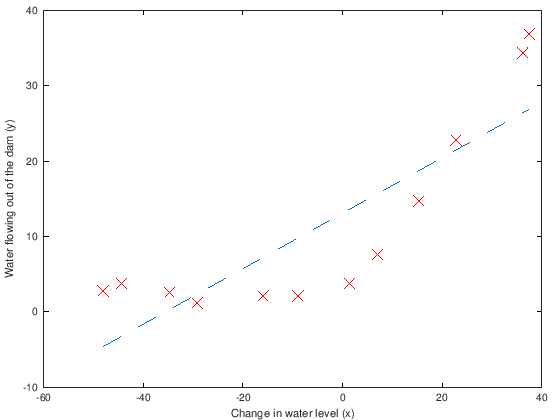

In [108]:
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 1.5);
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');
hold on;
x = linspace(min(X(:)),max(X(:)),50)';
plot(x, [ones(size(x,1), 1) x]*theta, '--', 'LineWidth', 2)
hold off;

## 3. Bias-Variace

### 3.1 Learning Curves -- `learningCurve.m`

Recall that for the computation of the learning curves the model parameters are fitted to an increasing number of examples: each step more examples. The obtained `theta` is fitted using regularization, i.e., our complete model. However, we compute the evaluation errors `J_train`, `J_cv` **without** regularization, because we want to know the error of the predicted values with respect to the ground truth data. The regularization term from teh cost makes sense only for the gradient computation, not for the real prediction error computation!

$$ J_{\text{train}} = \frac{1}{2m} \left[ \sum_{i=1}^m \left(h_\theta \left( x^{(i)} \right) - y^{(i)} \right)^2 \right] $$

In [109]:
function [error_train, error_val] = learningCurve_(X, y, Xval, yval, lambda)
    % Number of training examples
    % Also number of errors computed
    % X(1), X(1:2), X(1:3), ..., X(1:m): m errors with increasing number of examples used
    m = size(X, 1);

    % Init retun variables
    % error_train(i) must be computed using the theta obtained after training with i examples
    % error_val(i) must be obtained using the same theta by evaluating THE COMPLETE CV SPLIT!
    error_train = zeros(m, 1); % J_train
    error_val   = zeros(m, 1); % J_cv

    for k = 1:m
        % Fit theta with k examples WITH regularization
        [theta] = trainLinearReg([ones(k, 1) X(1:k,:)], y(1:k), lambda);
        % Compute J_train, without regularization, because we want the real error
        [J_train, grad] = linearRegCostFunction([ones(k, 1) X(1:k,:)], y(1:k), theta, 0);
        % Compute J_cv with entire CV split, because we want the real error
        [J_cv, grad] = linearRegCostFunction([ones(size(Xval,1), 1) Xval], yval, theta, 0);
        % Store the errors/costs
        error_train(k) = J_train;
        error_val(k) = J_cv;
    end
end


In [110]:
lambda = 0;
[error_train, error_val] = learningCurve_(X, y, Xval, yval, lambda);

ans = -53.739


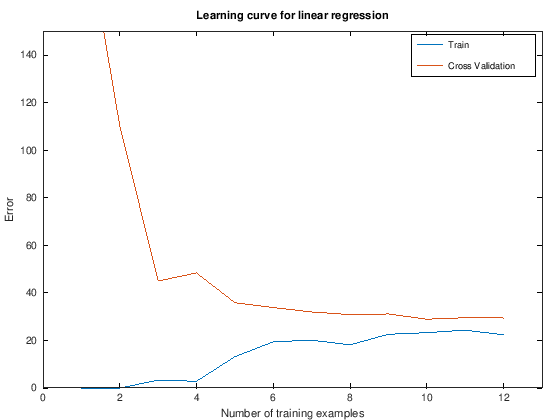

In [111]:
plot(1:m, error_train, 1:m, error_val);
title('Learning curve for linear regression')
legend('Train', 'Cross Validation')
xlabel('Number of training examples')
ylabel('Error')
axis([0 13 0 150])

## 4. Polynomial Regression

### 4.1 Polynomial Model -- `polyFeatures.m`

$$
\begin{align}
h_\theta(x)  &= \theta_0 + \theta_1 \times (\text{waterLevel}) + \theta_2 \times (\text{waterLevel})^2 + \cdots + \theta_p \times (\text{waterLevel})^p \\
& = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}
$$

In [112]:
function [X_poly] = polyFeatures_(X, p)
    X_poly = zeros(numel(X), p);
    for i = 1:p
        X_poly(:,i) = X.^i;
    end
end

In [113]:
[X_poly] = polyFeatures(X, 3)

X_poly =

  -1.5937e+01   2.5398e+02  -4.0476e+03
  -2.9153e+01   8.4990e+02  -2.4777e+04
   3.6190e+01   1.3097e+03   4.7397e+04
   3.7492e+01   1.4057e+03   5.2701e+04
  -4.8059e+01   2.3097e+03  -1.1100e+05
  -8.9415e+00   7.9950e+01  -7.1487e+02
   1.5308e+01   2.3433e+02   3.5871e+03
  -3.4706e+01   1.2045e+03  -4.1805e+04
   1.3892e+00   1.9297e+00   2.6807e+00
  -4.4384e+01   1.9699e+03  -8.7432e+04
   7.0135e+00   4.9189e+01   3.4499e+02
   2.2763e+01   5.1814e+02   1.1794e+04



### 4.2 Learning Polynomial Regression

Normalization is required.

In [114]:
function [X_norm] = applyNormalization(X, mu, sigma)
    X_norm = zeros(size(X));
    for i = 1:size(X,2)
        X_norm(:,i) = (X(:,i).-mu(1,i))./sigma(1,i);
    end
end

In [115]:
function [X_norm, mu, sigma] = featureNormalize_(X)
    mu = mean(X);
    sigma = std(X);
    %X_norm = bsxfun(@minus, X, mu);
    %X_norm = bsxfun(@rdivide, X_norm, sigma);
    X_norm = applyNormalization(X, mu, sigma);
end

In [116]:
[X_norm, mu, sigma] = featureNormalize_(X_poly)

X_norm =

  -3.6214e-01  -7.5509e-01   1.8223e-01
  -8.0320e-01   1.2583e-03  -2.4794e-01
   1.3775e+00   5.8483e-01   1.2498e+00
   1.4209e+00   7.0665e-01   1.3598e+00
  -1.4341e+00   1.8540e+00  -2.0372e+00
  -1.2869e-01  -9.7597e-01   2.5139e-01
   6.8058e-01  -7.8003e-01   3.4066e-01
  -9.8853e-01   4.5136e-01  -6.0128e-01
   2.1608e-01  -1.0750e+00   2.6628e-01
  -1.3115e+00   1.4228e+00  -1.5481e+00
   4.0378e-01  -1.0150e+00   2.7338e-01
   9.2938e-01  -4.1981e-01   5.1097e-01

mu =

  -5.0854e+00   8.4890e+02  -1.2829e+04

sigma =

   2.9964e+01   7.8789e+02   4.8190e+04



### Normalize, Learn/Train, & Plot Fitting Curve

In [117]:
p = 8;
X_poly = polyFeatures(X, p);
[X_poly, mu, sigma] = featureNormalize(X_poly);
X_poly = [ones(m, 1), X_poly];
% Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p);
X_poly_test = applyNormalization(X_poly_test, mu, sigma);
X_poly_test = [ones(size(X_poly_test, 1), 1), X_poly_test];
% Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p);
X_poly_val = applyNormalization(X_poly_val, mu, sigma);
X_poly_val = [ones(size(X_poly_val, 1), 1), X_poly_val];

In [126]:
lambda = 1;
[theta] = trainLinearReg(X_poly, y, lambda);

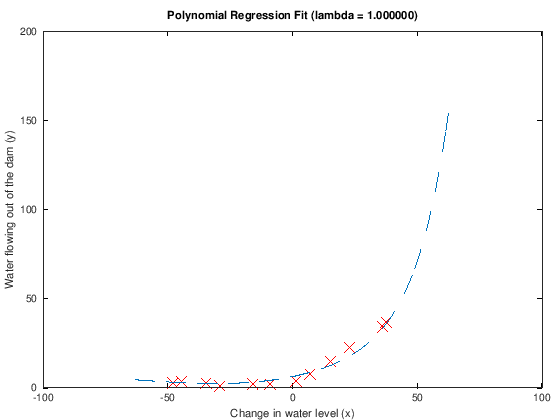

In [127]:
figure(1);
plot(X, y, 'rx', 'MarkerSize', 10, 'LineWidth', 1.5);
plotFit(min(X), max(X), mu, sigma, theta, p);
xlabel('Change in water level (x)');
ylabel('Water flowing out of the dam (y)');
title (sprintf('Polynomial Regression Fit (lambda = %f)', lambda));

### 4.3 Selecting `lambda` Usig a Cross-Validation Set -- `validationCurve.m`

In [147]:
function [lambda_vec, error_train, error_val] = validationCurve_(X, y, Xval, yval)

    % Selected values of lambda (you should not change this)
    lambda_vec = [0 0.001 0.003 0.01 0.03 0.1 0.3 1 3 10]';

    % Init retun variables
    % error_val(i) must be obtained using the same theta by evaluating THE COMPLETE CV SPLIT!
    error_train = zeros(length(lambda_vec), 1); % J_train
    error_val = zeros(length(lambda_vec), 1); % J_cv

    for k = 1:length(lambda_vec)
        lambda = lambda_vec(k);
        % Fit theta with k examples WITH regularization
        theta = trainLinearReg(X, y, lambda);
        % Compute J_train, without regularization, because we want the real error
        [J_train, grad] = linearRegCostFunction(X, y, theta, 0);
        % Compute J_cv with entire CV split, because we want the real error
        [J_cv, grad] = linearRegCostFunction(Xval, yval, theta, 0);
        % Store the errors/costs
        error_train(k) = J_train;
        error_val(k) = J_cv;
    end

end


In [148]:
[lambda_vec, error_train, error_val] = validationCurve_(X_poly, y, X_poly_val, yval);

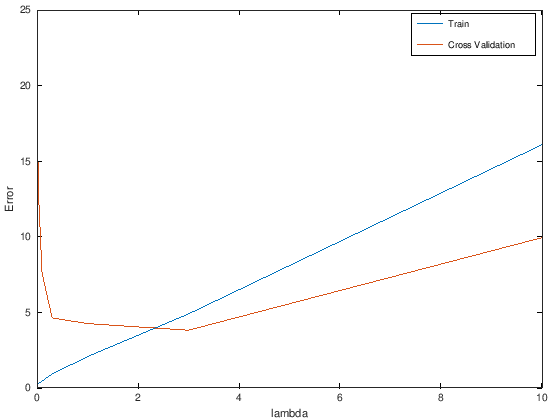

In [149]:
plot(lambda_vec, error_train, lambda_vec, error_val);
legend('Train', 'Cross Validation');
xlabel('lambda');
ylabel('Error');